In [38]:
mErde, mOzean, RErde, mMond, rMondBahn, TMondBahn, G = 5.9721986*10**24, 0.0014*10**24, 6.3675*10**6, 7.3459*10**22, 3.836*10**8, 27.32166140*24*3600, 6.67430*10**(-11)
TErdRotation = 86164.100        # s           : Heutige Periodendauer der intrinsischen Erdrotation
tau = 0.0021                    # s/100a      : Zunahme der Tageslänge auf der Erde in 100 Jahren

import numpy as np
import matplotlib.pyplot as plt
import math
import sympy
from scipy.constants import pi
import scipy
from scipy.integrate import solve_ivp
from scipy.integrate._ivp.ivp import OdeResult # :) https://github.com/scipy/scipy/blob/main/scipy/integrate/_ivp/ivp.py
from matplotlib.animation import FuncAnimation
from IPython.display import Image #to display animations

# Beautiful plots
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "Computer Modern Roman"

# Useful StackPosts
# https://stackoverflow.com/questions/59634279/solve-ivp-error-required-step-size-is-less-than-spacing-between-numbers

# Executing everything all the time takes too long
fastExecution = True

#### Custom Mathjax Befehle
Wenn ihr auch Lust habt damit rumzuspielen, man kann in Mathjax neue Commands erstellen ;)
$\newline$
Hier sind alle die ich bis jetzt gemacht habe (sieht man nicht).
$ \def\dv#1{ \frac{\mathrm{d}}{\mathrm{d} #1} } $
$ \def\dd#1{ \ \mathrm{d} #1 } $
$ \def\Vec#1{ \overrightarrow{#1} } $ Aus dem Physics package.
$ \def\VecT#1#2{ \begin{pmatrix} #1 \\ #2 \end{pmatrix} } $ 2D Vector
$ \def\VecE#1{ \hat{e}_{#1} } $ Einheitsvektor
Hier ein schöner StackExchange [Post](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference/11638#11638) dazu 

$\providecommand{\e}[1]{\ensuremath{\cdot 10^{#1}}}$ mit \e-9 kann man normale Scientific notation machen
$\providecommand{\fehlt}{\textcolor{red}{\textbf{Fehlt!\dots}}}$ benutze ich gerne in meinen LateX Dokumenten
$\providecommand{\todo}{\textcolor{red}{\textbf{\huge{ToDo}}}}$ benutze ich gerne in meinen LateX Dokumenten wenn noch was gemacht werden soll

#### Variablenbennung
Ich bin für:
$\newline$
$x_{\text{Anfangsbuchstabe des Körpers}} $ im Code `x_{Anfangsbuchstabe des Körpers}`
$\newline$
$vx_{\text{Anfangsbuchstabe des Körpers}} $, im Code `vx_{Anfangsbuchstabe des Körpers}`
$\newline$
$ax_{\text{Anfangsbuchstabe des Körpers}} $, im Code `ax_{Anfangsbuchstabe des Körpers}`
$\newline$
Für Winkel:
$\newline$
$\phi_{\text{Anfangsbuchstabe des Körpers}} $ im Code `phi_{Anfangsbuchstabe des Körpers}`
$\newline$
Für Winkelgeschwindigkeit:
$\newline$
$\omega_{\text{Anfangsbuchstabe des Körpers}} $ im Code `omega_{Anfangsbuchstabe des Körpers}`
$\newline$
Für Winkelbeschleunigung:
$\newline$
$\alpha_{\text{Anfangsbuchstabe des Körpers}} $ im Code `alpha_{Anfangsbuchstabe des Körpers}`
$\newline$
State Vektor:
$\newline$
Erst alle Positionen, dann alle Geschwindigkeiten, dann alle Beschleunigungen.
Postionen und Winkel gemischt und selbe Reihenfolge, möglichst nach Objekt grupiert. Konstanten am Schluss.

#### Zweikörperproblem

- Lösen Sie mit Ihren Implementierungen die Bewegungsgleichungen des Erde-Mond-Systems erneut. Vergleichen Sie die Ergebnisse untereinander und mit dem Ergebnis der obigen Funktion. Vergleichen Sie alle Ergebnisse auch mit der exakten Lösung des Zweikörperproblems.

In [20]:
# TODO: Solve the DGL and visualize the solution better, so that we can see the differences!
# TODO: write down the differences between the two methods and the exact solution!!

#### Vierkörperproblem mit Randbedingungen

- Erweitern Sie die obige Funktion um die beiden Flutberge, die sich auf der Erdoberfläche befinden.
    Dazu werden die beiden Flutberge als Punktmassen genähert, dessen Abstand zur Erde zu jeder Zeit dem Erdradius entspricht. Aufgrund dieser Zwangsbedingungen gestaltet sich die Herleitung der Bewegungsgleichungen als kompliziert. 
        
    Sei $\Vec{F_{ba}}$ die Gravitationskraft, die ein Körper $b$ auf einen Körper $a$ ausübt. Die gegenseitige Gravitationskraft der beiden Flutberge ist sehr gering und wird daher im Folgenden vernachlässigt, d.h. $\vec F_{21}$=$\vec F_{12}=0$. 
        
    Die radiale Kompenente der Kraft auf die beiden Flutberge muss so festgesetzt werden, dass ihr jeweiliger Abstand zur Erde gleich bleibt, also zu jeder Zeit dem Erdradius entspricht. Dies wird mit dem Einführen von radial gerichteten Zwangskräften bewerkstelligt. Da die Gravitationskraft von der Erde auf die Flutberge ebenfalls radial gerichtet ist, kann diese implizit in die Definition der Zwangskräfte mit eingebaut werden, $\vec F_{\mathrm{Z}1}$ und $\vec F_{\mathrm{Z}2}$ stellen also die Summe der jeweiligen Zwangskraft und der Gravitationskraft der Erde auf Flutberg 1 bzw. Flutberg 2 dar. Auf die Erde wirken diese Kräfte mit entgegengesetztem Vorzeichen. 
        
    Damit ergibt sich für die Gesamtkräfte $\vec F_\mathrm{E}$, $\vec F_\mathrm{M}$, $\vec F_1$, $\vec F_2$ auf Erde, Mond, Flutberg 1 bzw. Flutberg 2 folgendes Gleichungssystem:
    
$\newline$
\begin{align*}
    \vec F_\mathrm{E} &= \vec F_\mathrm{ME} - \vec F_{\mathrm{Z}1} - \vec F_{\mathrm{Z}2} \\
    \vec F_\mathrm{M} &= \vec F_\mathrm{EM} + \vec F_{1\mathrm{M}} + \vec F_{2\mathrm{M}} \\
    \vec F_1 &=  \vec F_{\mathrm{M}1} + \vec F_{\mathrm{Z}1} \\
    \vec F_2 &= \vec F_{\mathrm{M}2} + \vec F_{\mathrm{Z}2}      
\end{align*}

Die Koordinaten des $i$-ten Flutbergs lassen sich am elegantesten in Polarkoordinaten relativ zu den Erdkoordinaten $\vec r_\mathrm{E}$ angeben:
$\newline$
\begin{equation*}
    \vec r_i = \vec r_\mathrm{E} + R_\mathrm{E}\,\vec e_{r,i}\,,
\end{equation*}

wobei $\vec e_{r,i}$ den radialen Einheitsvektor in Bezug auf den $i$-ten Flutberg darstellt. Die Kraft auf den $i$-ten Flutberg lässt sich nun in einen radialen Anteil und einen Winkelanteil aufteilen:
$\newline$
\begin{align*}
    \vec F_i &= (\vec F_{\mathrm{M}i})_{\varphi,i} \vec e_{\varphi,i} + (\vec F_{\mathrm{M}i})_{r,i} \vec e_{r,i} + F_{\mathrm{Z}i} \vec e_{r,i} \\
    &= (\vec F_{\mathrm{M}i})_{\varphi,i} \vec e_{\varphi,i} + ((\vec F_{\mathrm{M}i})_{r,i} + F_{\mathrm{Z}i})\, \vec e_{r,i}\,. 
\end{align*}

Hierbei stellt $\vec e_{\varphi,i}$ den Einheitsvektor in $\varphi_i$-Richtung und $\varphi_i$ den Winkel des $i$-ten Flutbergs relativ zu den Erdkoordinaten dar. Die Beschleunigung des $i$-ten Flutberg in Richtung Erde muss der Zentripetalbeschleunigung für stabile Kreisbahnen abzüglich der Beschleunigung der Erde in radiale Richtung betragen, damit die Zwangsbedingung (ZB) erfüllt ist, d.h.
$\newline$
\begin{equation*}
    (\vec F_{\mathrm{M}i})_{r,i} + F_{\mathrm{Z}i} \stackrel{\mathrm{ZB}}{=} -m_i \left( R_\mathrm{E} \dot{\varphi}_i^2 - (\ddot{\vec r_\mathrm{E}})_{r,i} \right)\,,
\end{equation*}

wobei $m_i$ die Masse des $i$-ten Flutbergs ist. 
    
Dies lässt sich mit einer Analogie zum Fadenpendel verstehen, wobei die Masse am Pendel einem Flutberg bzw. der Aufhängepunkt der Erde entspricht. Jedoch muss hier zusätzlich berücksichtigt werden, dass die Erde im Gegensatz zum Aufhängepunkt beim Fadenpendel zusätzlich beschleunigt werden kann, weshalb die Beschleunigung der Erde in radiale Richtung von der Zentripetalbeschleunigung subtrahiert werden muss. So wird zum Beispiel die Zwangsbedingung bereits eingehalten, wenn die Erde in Richtung eines Flutbergs mit dem Betrag der Zentripetalbeschleunigung beschleunigt wird und auf den Flutberg keine radiale Beschleunigung wirkt. 
 
Aus den Kräftgleichungen lassen sich nun die benötigten Bewegungsgleichungen ablesen. Beachten Sie, dass die Gleichungen für die Flutberge jeweils nur eine Bewegungsgleichung bezüglich des jeweiligen Winkels liefern, während die Bewegungsgleichung bezüglich der radialen Koordinate aufgrund der Zwangsbedingung redundant ist. Im Gegensatz zu dieser Herleitung mit Newtonscher Mechanik lassen sich die Bewegungsgleichungen wesentlich leichter mit dem Lagrangeformalismus, welcher die Zwangsbedingungen auf eine natürliche Art implementiert, herleiten.
    
Mit den Bewegungsgleichungen in dieser Form lässt sich allerdings noch keine geeignete Funktion definieren, die zwecks Lösen des Systems an `solve_ivp()` übergeben werden kann, da die Bewegungsgleichungen für Erde und Flutberge mehrere zweite zeitliche Ableitungen der Koordinaten beinhalten. Daher muss das Gleichungssystem zunächst nach den verschiedenen Beschleunigungen umgestellt werden. Dafür eignet sich die _SymPy_-Funktion `linsolve()`. Anschließend können die damit erhaltenen symbolischen Ausdrücke in numerische Funktionen umgewandelt werden. Verwenden Sie hierzu unbedingt `lambdify()`, da `subs()` sehr viel Rechenzeit in Anpruch nimmt.
$\newline$    
- Betrachten Sie die zeitliche Entwicklung des Vierteilchensystems.
    - Teilen Sie dabei zunächst die Masse der Ozeane auf die beiden Flutberge gleichmäßig auf und lassen Sie die beiden Flutberge auf der Verbindungslinie zwischen Erde und Mond mit der Umlaufperiodendauer des Mondes starten. Passen Sie die Anfangsbedingungen so an, dass der Schwerpunkt wieder im Ursprung ruht.

Im Folgenden werden die Gleichungen, welche an `solve_ivp()` übergeben werden sollen, hergeleitet. $\newline$
Für die Flutberge werden Polarkoordinaten verwendet, es gilt also:
$\newline$
\begin{align*}
    x_i = x_\mathrm{E} + R_\mathrm{E}\cos{\varphi_i}\\
    y_i = y_\mathrm{E} + R_\mathrm{E}\sin{\varphi_i}
\end{align*}

Stellt man die Zwangsbedingung nach der Zwangskraft um und setzt in die Kraft auf die Erde ein, so erhält man:
$\newline$
\begin{align*}
    \vec F_\mathrm{E} &= \vec F_\mathrm{ME} + (m_1 \left( R_\mathrm{E} \dot{\varphi}_1^2 - (\ddot{\vec r_\mathrm{E}})_{r,1} \right)\, + (\vec F_{\mathrm{M}1})_{r,1})\vec e_{r,1} + (m_2 \left( R_\mathrm{E} \dot{\varphi}_i^2 - (\ddot{\vec r_\mathrm{E}})_{r,2} \right)\, + (\vec F_{\mathrm{M}i})_{r,2})\vec e_{r,2} \\      
\end{align*}

Die r-Komponente erhält man durch projektion mit dem entsprechenden Einheitsvektor $\vec e_{r,i}$, und es ergibt sich mit umstellen der Gleichung:
$\newline$
\begin{align*}
    \ddot{x}_\mathrm{E} = \frac{1}{\mu_x} (a(x_\mathrm{M} - x_\mathrm{E}) - b\ddot{y_\mathrm{E}} + c_1\cos{\varphi_1} + c_2\cos{\varphi_2})\\
    \ddot{y}_\mathrm{E} = \frac{1}{\mu_y} (a(y_\mathrm{M} - y_\mathrm{E}) - b\ddot{x_\mathrm{E}} + c_1\sin{\varphi_1} + c_2\sin{\varphi_2})
\end{align*}

Mit:
$\newline$
\begin{align*}
    \mu_x &= m_\mathrm{E} + m_1\cos{\varphi_1}^2 + m_2\cos{\varphi_2}^2\\
    \mu_y &= m_\mathrm{E} + m_1\sin{\varphi_1}^2 + m_2\sin{\varphi_2}^2\\
    a &= \frac{Gm_\mathrm{M}m_\mathrm{E}}{((x_\mathrm{M} - x_\mathrm{E})^2 + (y_\mathrm{M} - y_\mathrm{E})^2)^{\frac{3}{2}}}\\
    b &= m_1\sin{\varphi_1}\cos{\varphi_1} + m_2\sin{\varphi_2}\cos{\varphi_2}\\
    c_i &= m_iR_\mathrm{E}\dot{\varphi}_i^2 + \frac{Gm_\mathrm{M}m_i((x_\mathrm{M} - x_i)\cos{\varphi_i} + (y_\mathrm{M} - y_i)\sin{\varphi_i})}{((x_\mathrm{M} - x_i)^2 + (y_\mathrm{M} - y_i)^2)^{\frac{3}{2}}}
\end{align*}

Um diese Differentialgleichungen an `solve_ivp()` zu übergeben müssen sie noch entkoppelt werden.
Hierzu setzen wir $\ddot{y}_\mathrm{E}$ in die Gleichung für $\ddot{x}_\mathrm{E}$ ein, und stellen nach $\ddot{x}_\mathrm{E}$ um:
$\newline$
\begin{align*}
    \ddot{x}_\mathrm{E} = \frac{a(x_\mathrm{M} - x_\mathrm{E}) + c_1\cos{\varphi_1} + c_2\cos{\varphi_2}}{\mu_x - \frac{b^2}{\mu_y}}
\end{align*}

Die Kraft auf den Mond lässt sich mit der Gravitationskraft einfach durch einsetzen bestimmen, was zu folgenden Gleichungen führt:
$\newline$
\begin{align*}
    \ddot{x}_\mathrm{M} =   G(\frac{m_\mathrm{E}(x_\mathrm{E} - x_\mathrm{M})}{((x_\mathrm{E} - x_\mathrm{M})^2 + (y_\mathrm{E} - y_\mathrm{M})^2)^{\frac{3}{2}}}
                            + \frac{m_1(x_1 - x_\mathrm{M})}{((x_1 - x_\mathrm{M})^2 + (y_1 - y_\mathrm{M})^2)^{\frac{3}{2}}}
                            + \frac{m_2(x_2 - x_\mathrm{M})}{((x_2 - x_\mathrm{M})^2 + (y_2 - y_\mathrm{M})^2)^{\frac{3}{2}}})\\
    \ddot{y}_\mathrm{M} =   G(\frac{m_\mathrm{E}(y_\mathrm{E} - y_\mathrm{M})}{((x_\mathrm{E} - x_\mathrm{M})^2 + (y_\mathrm{E} - y_\mathrm{M})^2)^{\frac{3}{2}}}
                            + \frac{m_1(y_1 - y_\mathrm{M})}{((x_1 - x_\mathrm{M})^2 + (y_1 - y_\mathrm{M})^2)^{\frac{3}{2}}}
                            + \frac{m_2(y_2 - y_\mathrm{M})}{((x_2 - x_\mathrm{M})^2 + (y_2 - y_\mathrm{M})^2)^{\frac{3}{2}}})\\
\end{align*}

Für die Kraft auf die Flutberge kann die Zwangskraft in der Form, in der sie angegeben ist eingesetzt werden:
$\newline$
\begin{align*}
    \vec F_i = (\vec F_{\mathrm{M}i})_{\varphi,i} \vec e_{\varphi,i} -(m_i \left( R_\mathrm{E} \dot{\varphi}_i^2 - (\ddot{\vec r_\mathrm{E}})_{r,i} \right)\,)\, \vec e_{r,i}\,. \\
\end{align*}

Die r- bzw. $\varphi$-Komponente erhält man wieder mit den entsprechenden Einheitsvektoren, und wir erhalten:
$\newline$
\begin{align*}
    \ddot{x}_i =   -\frac{Gm_\mathrm{M}((y_\mathrm{M} - y_i)\cos{\varphi_i} - (x_\mathrm{M} - x_i)\sin{\varphi_i})}{((x_\mathrm{M} - x_i)^2 + (y_\mathrm{M} - y_i)^2)^{\frac{3}{2}}}\sin{\varphi_i}
                    - (R_\mathrm{E}\dot{\varphi_i}^2 - (\ddot{x}_\mathrm{E}\cos{\varphi_i} + \ddot{y}_\mathrm{E}\sin{\varphi_i}))\cos{\varphi_i}\\
    \ddot{y}_i =   \frac{Gm_\mathrm{M}((y_\mathrm{M} - y_i)\cos{\varphi_i} - (x_\mathrm{M} - x_i)\sin{\varphi_i})}{((x_\mathrm{M} - x_i)^2 + (y_\mathrm{M} - y_i)^2)^{\frac{3}{2}}}\cos{\varphi_i}
                    - (R_\mathrm{E}\dot{\varphi_i}^2 - (\ddot{x}_\mathrm{E}\cos{\varphi_i} + \ddot{y}_\mathrm{E}\sin{\varphi_i}))\sin{\varphi_i}
\end{align*}

Wir brauchen aber $\ddot{\varphi_i}$, dazu leiten wir die Koordinaten der Flutberge zwei mal nach der Zeit ab:
$\newline$
\begin{align*}
    \ddot{\vec r_i} = \ddot{\vec r_\mathrm{E}} + R_\mathrm{E}(\ddot{\varphi_i}\vec e_{\varphi,i}\, - \dot{\varphi_i}^2\vec e_{r,i}\,)\\
    \ddot{\varphi_i}\vec e_{\varphi,i}\, = \frac{\ddot{\vec r_i} - \ddot{\vec r_\mathrm{E}}}{R_\mathrm{E}} + \dot{\varphi_i}^2\vec e_{r,i}\,
\end{align*}

Durch multiplikation mit $\vec e_{\varphi,i}\,$ erhält man:
$\newline$
\begin{align*}
    \ddot{\varphi_i} = \frac{-(\ddot{x}_i - \ddot{x}_\mathrm{E})\sin{\varphi_i} + (\ddot{y}_i - \ddot{y}_\mathrm{E})\cos{\varphi_i}}{R_\mathrm{E}}
\end{align*}

##### Lösen mit `sympy`

In [21]:
# TODO Define starting conditions beforehands

t = sympy.symbols('t', real=True, positive=True) # Time variable for all functions
x_E, y_E, x_M, y_M, phi_1, phi_2 = sympy.symbols('x_E, y_E, x_M, y_M, phi_1, phi_2', real=True, cls=sympy.Function)
x_E, y_E, x_M, y_M, phi_1, phi_2 = x_E(t), y_E(t), x_M(t), y_M(t), phi_1(t), phi_2(t) # The functions are functions of time

# Define masses for the tides
m1, m2 = mOzean/2, mOzean/2

# Distances between the bodies
dist_em, dist_m1, dist_m2 = sympy.symbols('d_em, d_m1, d_m2', real=True, positive=True)

# Coordinate vectors of the tides
r_1 = sympy.Matrix([x_E + RErde*sympy.cos(phi_1), y_E + RErde*sympy.sin(phi_1)])
r_2 = sympy.Matrix([x_E + RErde*sympy.cos(phi_2), y_E + RErde*sympy.sin(phi_2)])

# Force vectors
F_ME = -G*mErde*mMond / (dist_em**3) * sympy.Matrix([x_E-x_M, y_E-y_M]) 
F_1M = -G*mMond*m1    / (dist_m1**3) * (sympy.Matrix([x_M, y_M]) - r_1)
F_2M = -G*mMond*m2    / (dist_m2**3) * (sympy.Matrix([x_M, y_M]) - r_2)

# Polar unit vectors for phi_1 and phi_2
e_r_1 = sympy.Matrix([sympy.cos(phi_1), sympy.sin(phi_1)])
e_phi_1 = sympy.Matrix([-sympy.sin(phi_1), sympy.cos(phi_1)])
e_r_2 = sympy.Matrix([sympy.cos(phi_2), sympy.sin(phi_2)])
e_phi_2 = sympy.Matrix([-sympy.sin(phi_2), sympy.cos(phi_2)])

# The radial component of the earth's acceleration vector
a_E_r = sympy.Matrix([x_E.diff(t, t), y_E.diff(t, t)])

# Constraint force vectors on the tides
F_Z1 = (F_1M.dot(e_r_1) + m1*(RErde*(phi_1.diff(t))**2 - a_E_r.dot(e_r_1))) * e_r_1
F_Z2 = (F_2M.dot(e_r_2) + m2*(RErde*(phi_2.diff(t))**2 - a_E_r.dot(e_r_2))) * e_r_2

# Forces on the tides
F_1 = F_1M.dot(e_phi_1) * e_phi_1 - (m1* (RErde*phi_1.diff(t)**2 - a_E_r.dot(e_r_1))) * e_r_1
F_2 = F_2M.dot(e_phi_2) * e_phi_2 - (m2* (RErde*phi_2.diff(t)**2 - a_E_r.dot(e_r_2))) * e_r_2

# We now write the equations of motion
eq1 = sympy.Eq(mErde * x_E.diff(t, t), (F_ME[0] + F_Z1[0] + F_Z2[0]))
eq2 = sympy.Eq(mErde * y_E.diff(t, t), (F_ME[1] + F_Z1[1] + F_Z2[1]))
eq3 = sympy.Eq(mMond * x_M.diff(t, t), (-F_ME[0] + F_1M[0] + F_2M[0]))
eq4 = sympy.Eq(mMond * y_M.diff(t, t), (-F_ME[1] + F_1M[1] + F_2M[1]))
eq5 = sympy.Eq(m1*(r_1[0]).diff(t, t), F_1[0])
eq6 = sympy.Eq(m1*(r_1[1]).diff(t, t), F_1[1])
eq7 = sympy.Eq(m2*(r_2[0]).diff(t, t), F_2[0])
eq8 = sympy.Eq(m2*(r_2[1]).diff(t, t), F_2[1])

equations = [eq1, eq2, eq3, eq4, eq5, eq6, eq7, eq8]

# Replace the derivates and functions with symbols
old_variables = [x_E, y_E, x_M, y_M, phi_1, phi_2, x_E.diff(t), y_E.diff(t), x_M.diff(t), y_M.diff(t), phi_1.diff(t), phi_2.diff(t), x_E.diff(t, t), y_E.diff(t, t), x_M.diff(t, t), y_M.diff(t, t), phi_1.diff(t, t), phi_2.diff(t, t)]
variables = sympy.symbols('x_E, y_E, x_M, y_M, phi_1, phi_2 \dot{x_E}, \dot{y}_E, \dot{x}_M, \dot{y}_M, \dot{\phi}_1, \dot{\phi}_2 \ddot{x}_E, \ddot{y}_E, \ddot{x}_M, \ddot{y}_M, \ddot{\phi}_1, \ddot{\phi}_2', real=True)
x_E, y_E, x_M, y_M, phi_1, phi_2, x_E_dot, y_E_dot, x_M_dot, y_M_dot, phi_1_dot, phi_2_dot, x_E_ddot, y_E_ddot, x_M_ddot, y_M_ddot, phi_1_ddot, phi_2_ddot = variables
variable_replacements = {key: value for key, value in zip(old_variables, variables)}

equations_var = [eq.subs(variable_replacements) for eq in equations] # Replace the variables in the differential equations
    
# Distances as equations for replacing the constants
dist_em_eq = sympy.sqrt((x_E-x_M)**2+(y_E-y_M)**2)
dist_m1_eq = sympy.sqrt((x_M-x_E-RErde*sympy.cos(phi_1))**2+(y_M-y_E-RErde*sympy.sin(phi_1))**2)
dist_m2_eq = sympy.sqrt((x_M-x_E-RErde*sympy.cos(phi_2))**2+(y_M-y_E-RErde*sympy.sin(phi_2))**2)

# Solving the equations for the moon
moon_acc = sympy.linsolve(equations_var[2:4], variables[14:16])
moon_acc_final = [eq.subs({dist_em: dist_em_eq, dist_m1: dist_m1_eq, dist_m2: dist_m2_eq}) for eq in moon_acc.args[0]]

# Solving the equations for the earth
# We define symbols to make linsolve faster
mu_xs, mu_ys, a, b, c11, c13, c21, c23, c31, c33, c41, c43 = sympy.symbols('mu_xs, mu_ys, a, b, c_11, c13, c_21, c_23, c_31, c_33, c_41, c_43', real=True)

# Replace parts of the equations with symbols, these are similar but not exactly the same as the symbols in the description above
earth_x_rhs = (equations_var[0].rhs)
mu_x_eq = earth_x_rhs.expand().collect(x_E_ddot).coeff(x_E_ddot)
earth_x_rhs = earth_x_rhs.expand().collect(x_E_ddot).subs({mu_x_eq: mu_xs})
b_eq = earth_x_rhs.expand().collect(y_E_ddot).coeff(y_E_ddot)
earth_x_rhs = earth_x_rhs.expand().collect(y_E_ddot).subs({b_eq: b})
a_eq = earth_x_rhs.expand().collect(x_M).collect(x_E).coeff(x_M) 
earth_x_rhs = earth_x_rhs.expand().collect(x_M).collect(x_E).subs({a_eq: a})
exprCos = earth_x_rhs.expand().collect(sympy.cos(phi_1)).collect(sympy.cos(phi_2))
c11_eq = exprCos.coeff(sympy.cos(phi_1))
c21_eq = exprCos.coeff(sympy.cos(phi_2))
c13_eq = exprCos.coeff(sympy.cos(phi_1)**3)*sympy.cos(phi_1)**2
c23_eq = exprCos.coeff(sympy.cos(phi_2)**3)*sympy.cos(phi_2)**2
earth_x_rhs = earth_x_rhs.expand().collect(sympy.cos(phi_1)).collect(sympy.cos(phi_2)).subs({c11_eq: c11, c21_eq: c21, c13_eq: c13, c23_eq: c23})

earth_y_rhs = (equations_var[1].rhs)
mu_y_eq = earth_y_rhs.expand().collect(y_E_ddot).coeff(y_E_ddot)
earth_y_rhs = earth_y_rhs.expand().collect(y_E_ddot).subs({mu_y_eq: mu_ys})
b_eq = earth_y_rhs.expand().collect(x_E_ddot).coeff(x_E_ddot)
earth_y_rhs = earth_y_rhs.expand().collect(x_E_ddot).subs({b_eq: b})
a_eq = earth_y_rhs.expand().collect(y_M).collect(y_E).coeff(y_M)
earth_y_rhs = earth_y_rhs.expand().collect(y_M).collect(y_E).subs({a_eq: a})
exprSin = earth_y_rhs.expand().collect(sympy.sin(phi_1)).collect(sympy.sin(phi_2))
c31_eq = exprSin.coeff(sympy.sin(phi_1))
c41_eq = exprSin.coeff(sympy.sin(phi_2))
c33_eq = exprSin.coeff(sympy.sin(phi_1)**3)*sympy.sin(phi_1)**2
c43_eq = exprSin.coeff(sympy.sin(phi_2)**3)*sympy.sin(phi_2)**2
earth_y_rhs = earth_y_rhs.expand().collect(sympy.sin(phi_1)).collect(sympy.sin(phi_2)).subs({c31_eq: c31, c41_eq: c41, c33_eq: c33, c43_eq: c43})

# Rewrite the equations with the substituted symbols and solve
simplified_earth_x = sympy.Eq(equations_var[0].lhs, earth_x_rhs)
simplified_earth_y = sympy.Eq(equations_var[1].lhs, earth_y_rhs)
earth_acc = sympy.linsolve([simplified_earth_x, simplified_earth_y], [x_E_ddot, y_E_ddot])
earth_acc_final = [eq.subs({mu_xs: mu_x_eq, mu_ys: mu_y_eq, a: a_eq, b: b_eq, c11: c11_eq, c13: c13_eq, c21: c21_eq, c23: c23_eq, c31: c31_eq, c33: c33_eq, c41: c41_eq, c43: c43_eq}).subs({dist_em: dist_em_eq, dist_m1: dist_m1_eq, dist_m2: dist_m2_eq}) for eq in earth_acc.args[0]]

# Solve the equations for the tides
phi_1_acc = ((-(equations_var[4].rhs/ m1 - earth_acc_final[0])*sympy.sin(phi_1) + (equations_var[5].rhs/ m1 - earth_acc_final[1])*sympy.cos(phi_1))/(RErde)).subs({dist_em: dist_em_eq, dist_m1: dist_m1_eq, dist_m2: dist_m2_eq}).subs({x_E_ddot: earth_acc_final[0], y_E_ddot: earth_acc_final[1]})
phi_2_acc = ((-(equations_var[6].rhs/ m2 - earth_acc_final[0])*sympy.sin(phi_2) + (equations_var[7].rhs/ m2 - earth_acc_final[1])*sympy.cos(phi_2))/(RErde)).subs({dist_em: dist_em_eq, dist_m1: dist_m1_eq, dist_m2: dist_m2_eq}).subs({x_E_ddot: earth_acc_final[0], y_E_ddot: earth_acc_final[1]})

# Lambdify the equations for faster computation
lambdified_accelerations = [sympy.lambdify(variables[0:12], acc, 'numpy') for acc in earth_acc_final + moon_acc_final + [phi_1_acc, phi_2_acc]]

def eq_motion_4body_sympy(t, state, mass):
    x_E, y_E, x_M, y_M, phi_1, phi_2, vx_E, vy_E, vx_M, vy_M, omega_1, omgea_2 = state
    ax_E = lambdified_accelerations[0](x_E, y_E, x_M, y_M, phi_1, phi_2, vx_E, vy_E, vx_M, vy_M, omega_1, omgea_2)
    ay_E = lambdified_accelerations[1](x_E, y_E, x_M, y_M, phi_1, phi_2, vx_E, vy_E, vx_M, vy_M, omega_1, omgea_2)
    ax_M = lambdified_accelerations[2](x_E, y_E, x_M, y_M, phi_1, phi_2, vx_E, vy_E, vx_M, vy_M, omega_1, omgea_2)
    ay_M = lambdified_accelerations[3](x_E, y_E, x_M, y_M, phi_1, phi_2, vx_E, vy_E, vx_M, vy_M, omega_1, omgea_2)
    alpha_1 = lambdified_accelerations[4](x_E, y_E, x_M, y_M, phi_1, phi_2, vx_E, vy_E, vx_M, vy_M, omega_1, omgea_2)
    alpha_2 = lambdified_accelerations[5](x_E, y_E, x_M, y_M, phi_1, phi_2, vx_E, vy_E, vx_M, vy_M, omega_1, omgea_2)
    return [vx_E, vy_E, vx_M, vy_M, omega_1, omgea_2, ax_E, ay_E, ax_M, ay_M, alpha_1, alpha_2]

# TODO Make plot for half a month

##### Gleichungen per Hand

Trotzdem ist es sinnvoler die Gleichungen per Hand zu lösen, da `sympy` die Gleichungen nicht in "normaler" Zeit vereinfachen kann,
das heißt, dass man ein wenig Rechenzeit sparen kann, wenn man es per Hand macht.
Dieses "nicht vereinfachen" der Gleichungen führt zu einer Verlängerung der Laufzeit um ungefähr 810%,
hier ist natürlich noch Optimierungspotential vorhanden, da die Gleichungen noch nicht vollständig vereinfacht sind.
Das Vereinfachen dauert aber ebenfalls sehr sehr lange.
Diese nicht vereinfachten Gleichungen führen auch zu mehr numerischen Fehlern.

In [22]:
def tides_acceleration(x_E, y_E, vx_Ed, vy_Ed, x_M, y_M, phi_i, omega_i, m_M):
    '''Calculates the angular acceleration of a tide, using the equation above'''
    vx_id = -G*(m_M*((y_M - (y_E + RErde*np.sin(phi_i)))*np.cos(phi_i) - (x_M - (x_E + RErde*np.cos(phi_i)))*np.sin(phi_i))) / ((x_M - (x_E + RErde*np.cos(phi_i)))**2 + (y_M - (y_E + RErde*np.sin(phi_i)))**2)**(3/2) * np.sin(phi_i) -(RErde*omega_i**2 - (vx_Ed*np.cos(phi_i) + vy_Ed*np.sin(phi_i)))*np.cos(phi_i)
    vy_id = G*(m_M*((y_M - (y_E + RErde*np.sin(phi_i)))*np.cos(phi_i) - (x_M - (x_E + RErde*np.cos(phi_i)))*np.sin(phi_i))) / ((x_M - (x_E + RErde*np.cos(phi_i)))**2 + (y_M - (y_E + RErde*np.sin(phi_i)))**2)**(3/2) * np.cos(phi_i) -(RErde*omega_i**2 - (vx_Ed*np.cos(phi_i) + vy_Ed*np.sin(phi_i)))*np.sin(phi_i)
    alpha_i = (-(vx_id - vx_Ed)*np.sin(phi_i) + (vy_id - vy_Ed)*np.cos(phi_i))/RErde

    return alpha_i

def eq_motion_4body(t, state, mass):
    '''This function calculates the derivatives of the state vector for a specific 4 body problem (Earth-Moon with tidal forces) to be passed to solve_ivp. \\
    state: state vector is given by [x_E, y_E, x_M, y_M, phi_1, phi_2, vx_E, vy_E, vx_M, vy_M, omega_1, omgea_2].
    mass: list of the masses of the two bodys. e.g. [m_E, m_M, m1, m2]'''
    x_E, y_E, x_M, y_M, phi_1, phi_2, vx_E, vy_E, vx_M, vy_M, omega_1, omgea_2 = state
    m_E, m_M, m_1, m_2 = mass

    # Variables as defined in the explanation above
    mu_x = m_E + m_1*np.cos(phi_1)**2 + m_2*np.cos(phi_2)**2
    mu_y = m_E + m_1*np.sin(phi_1)**2 + m_2*np.sin(phi_2)**2
    a = (G*m_M*m_E)/((x_M - x_E)**2 + (y_M - y_E)**2)**(3/2)
    b = m_1*np.sin(phi_1)*np.cos(phi_1) + m_2*np.sin(phi_2)*np.cos(phi_2)
    x_1 = x_E + RErde*np.cos(phi_1)
    y_1 = y_E + RErde*np.sin(phi_1)
    x_2 = x_E + RErde*np.cos(phi_2)
    y_2 = y_E + RErde*np.sin(phi_2)
    c1 = m_1*RErde*omega_1**2 + (G*m_M*m_1*((x_M - x_1)*np.cos(phi_1) + (y_M - y_1)*np.sin(phi_1)))/((x_M - x_1)**2 + (y_M - y_1)**2)**(3/2)
    c2 = m_2*RErde*omgea_2**2 + (G*m_M*m_2*((x_M - x_2)*np.cos(phi_2) + (y_M - y_2)*np.sin(phi_2)))/((x_M - x_2)**2 + (y_M - y_2)**2)**(3/2)

    # The earth's acceleration:    
    ax_E = 1/(mu_x - b**2/mu_y) * (a*(x_M - x_E) -b/mu_y*(a*(y_M - y_E) + c1*np.sin(phi_1) + c2*np.sin(phi_2)) + c1*np.cos(phi_1) + c2*np.cos(phi_2))
    ay_E = 1/mu_y*(a*(y_M - y_E) - b*ax_E + c1*np.sin(phi_1) + c2*np.sin(phi_2))

    # The moon's acceleration:
    ax_M = G*((m_E*(x_E - x_M))/((x_E - x_M)**2 + (y_E - y_M)**2)**(3/2) + (m_1*(x_1 - x_M))/((x_1 - x_M)**2 + (y_1 - y_M)**2)**(3/2) + (m_2*(x_2 - x_M))/((x_2 - x_M)**2 + (y_2 - y_M)**2)**(3/2))
    ay_M = G*((m_E*(y_E - y_M))/((x_E - x_M)**2 + (y_E - y_M)**2)**(3/2) + (m_1*(y_1 - y_M))/((x_1 - x_M)**2 + (y_1 - y_M)**2)**(3/2) + (m_2*(y_2 - y_M))/((x_2 - x_M)**2 + (y_2 - y_M)**2)**(3/2))

    # Tides angular acceleration:
    alpha_1 = tides_acceleration(x_E, y_E, ax_E, ay_E, x_M, y_M, phi_1, omega_1, m_M)
    alpha_2 = tides_acceleration(x_E, y_E, ax_E, ay_E, x_M, y_M, phi_2, omgea_2, m_M)

    return[vx_E, vy_E, vx_M, vy_M, omega_1, omgea_2, ax_E, ay_E, ax_M, ay_M, alpha_1, alpha_2]

# Fehler in c1, c2 fehlt sin/cos bei zweiter diff über dem Bruch
# Mond zweiter summand y_1 falsch, dritter summand auch

In [36]:
def baryzentrum(m1, m2, r): return r*m2/(m1+m2) # TODO Remove, redundant

def center_of_mass(m1, m2, m3, m4, x_1, y_1, x_2, y_2, x_3, y_3, x_4, y_4): # TODO Remove, not used
    '''Returns the coordinates of the center of mass of the system'''
    x = (m1*x_1 + m2*x_2 + m3*x_3 + m4*x_4)/(m1 + m2 + m3 + m4)
    y = (m1*y_1 + m2*y_2 + m3*y_3 + m4*y_4)/(m1 + m2 + m3 + m4)
    return [x, y]

def iv_stable_orbit_4body():
    '''Initial conditions for the Earth-Moon-Tides system in a stable orbit'''
    # Each of the tides gets half of the oceans mass 
    mass = [mErde, mMond, mOzean/2, mOzean/2]
    
    # We want the center of mass to be at the origin, the tides count towards the earth,
    # but weigh so little that the center of mass doesn't really change
    abstand_baryzentrum_erde = baryzentrum(mErde + mOzean, mMond, rMondBahn)
    x0_Erde = [-abstand_baryzentrum_erde, 0]
    x0_Mond = [rMondBahn - abstand_baryzentrum_erde, 0]

    # We choose the starting velocities such that the center of mass is at rest
    vy0_Erde = 2*pi*abstand_baryzentrum_erde/TMondBahn
    vy0_Mond = 2*pi*(rMondBahn-abstand_baryzentrum_erde)/TMondBahn

    # The moon starts in positive, the earth in negative y-direction
    v0_Erde = [0, -vy0_Erde]
    v0_Mond = [0, vy0_Mond]

    # The tides start on the same axis as the moon on opposite sides of the earth
    phi_1 = 0
    phi_2 = pi

    # The tides start with the same velocity as the moon
    omega_1 = 2*pi/TMondBahn
    omega_2 = 2*pi/TMondBahn

    return [x0_Erde, x0_Mond, phi_1, phi_2, v0_Erde, v0_Mond, omega_1, omega_2, mass]

def four_body_problem(pos_body_1: list, pos_body_2: list, phi_1: float, phi_2: float, vel_body_1: list, vel_body_2: list, omega_1: float, omega_2: float, mass: list, t_max: float, steps=1, method='RK45', t_start=0):
    mass = [mErde, mMond, mOzean/2, mOzean/2]
    solution = solve_ivp(fun=eq_motion_4body, t_span=[t_start, t_max], y0=[*pos_body_1, *pos_body_2, phi_1, phi_2, *vel_body_1, *vel_body_2, omega_1, omega_2], args=(mass,), rtol=1e-12, atol=1e-12)
    x_E, y_E, x_M, y_M, phi_1, phi_2, vx_E, vy_E, vx_M, vy_M, omega_1, omega_2 = solution.y
    return [solution.t, x_E, y_E, x_M, y_M, phi_1, phi_2]

t, x_E, y_E, x_M, y_M, phi_1, phi_2 = four_body_problem(*iv_stable_orbit_4body(), 100*TMondBahn)

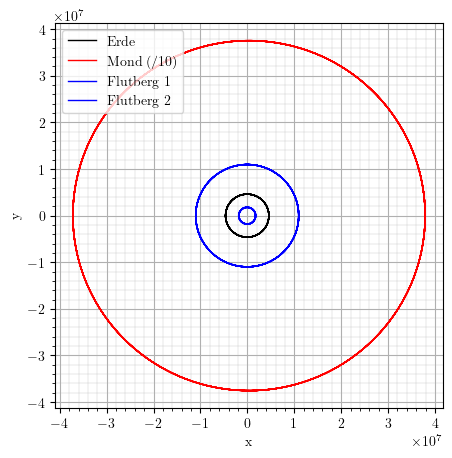

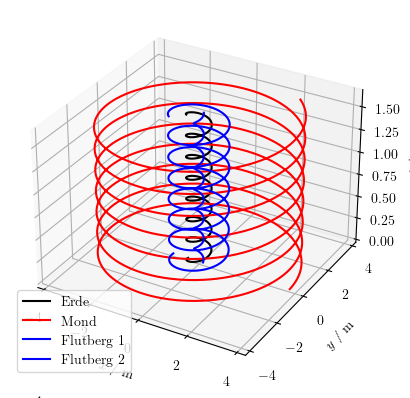

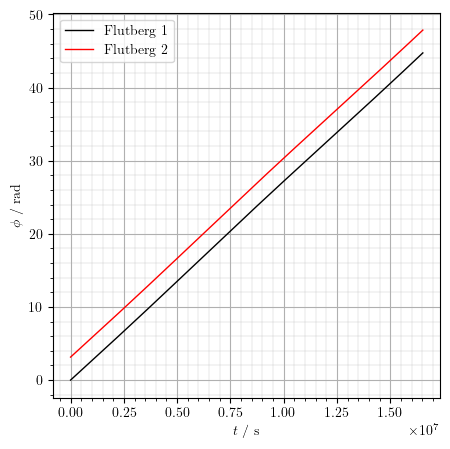

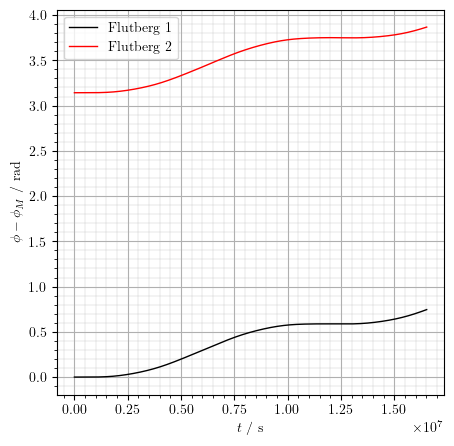

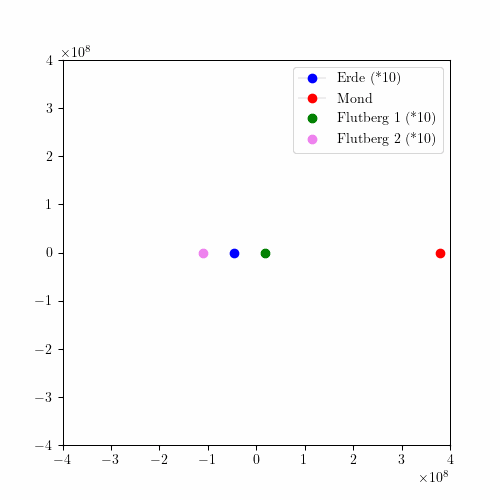

In [37]:
x_1, y_1 = x_E + RErde*np.cos(phi_1), y_E + RErde*np.sin(phi_1)
x_2, y_2 = x_E + RErde*np.cos(phi_2), y_E + RErde*np.sin(phi_2)

plt.rc('axes', axisbelow=True)
plt.figure(figsize=(5, 5))
plt.grid('minor', 'minor', linestyle='-', linewidth=0.2)
plt.grid('major', 'major', linestyle='-', linewidth=0.8)
plt.minorticks_on()
plt.xlabel("x")
plt.ylabel("y")

plt.plot(x_E, y_E, 'k', linewidth=1, label='Erde')
plt.plot(x_M/10, y_M/10, 'r', linewidth=1, label='Mond (/10)')
plt.plot(x_1, y_1, 'b', linewidth=1, label='Flutberg 1')
plt.plot(x_2, y_2, 'b', linewidth=1, label='Flutberg 2')

plt.legend()
plt.show()
plt.close()

# Plot a 3d phase space diagram
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.plot(x_E, y_E, t, 'k', label='Erde')
ax.plot(x_M/10, y_M/10, t, 'r', label='Mond')
ax.plot(x_1, y_1, t, 'b', label='Flutberg 1')
ax.plot(x_2, y_2, t, 'b', label='Flutberg 2')
ax.set_xlabel("$x$ / m")
ax.set_ylabel("$y$ / m")
ax.set_zlabel("$t$ / s")
ax.legend()
plt.show()
plt.close()

# Plot the change of the center of mass over time
fig, ax = plt.subplots()
fig.set_label("Bewegung des Baryzentrum des Erde-Mond-Systems")
ax.plot(t, center_of_mass(mErde, mMond, mOzean/2, mOzean/2, x_E, y_E, x_M, y_M, x_1, y_1, x_2, y_2)[0], color='blue', label='x-Koordinate des Schwerpunkts')
ax.plot(t, center_of_mass(mErde, mMond, mOzean/2, mOzean/2, x_E, y_E, x_M, y_M, x_1, y_1, x_2, y_2)[1], color='red', label='y-Koordinate des Schwerpunkts')
ax.set_xlabel('Zeit $t$ / s')
ax.set_ylabel('Position $x$ / m')
ax.set_title('Baryzentrum')
ax.legend()
plt.show()
plt.close()

# Plot the angles of the tides over time
plt.rc('axes', axisbelow=True)
plt.figure(figsize=(5, 5))
plt.grid('minor', 'minor', linestyle='-', linewidth=0.2)
plt.grid('major', 'major', linestyle='-', linewidth=0.8)
plt.minorticks_on()
plt.xlabel("$t$ / s")
plt.ylabel("$\phi$ / rad")

plt.plot(t, phi_1, 'k', linewidth=1, label='Flutberg 1')
plt.plot(t, phi_2, 'r', linewidth=1, label='Flutberg 2')

plt.legend()
plt.show()
plt.close()

# Plot the angles of the tides over time, subtracting the angle of the moon
plt.rc('axes', axisbelow=True)
plt.figure(figsize=(5, 5))
plt.grid('minor', 'minor', linestyle='-', linewidth=0.2)
plt.grid('major', 'major', linestyle='-', linewidth=0.8)
plt.minorticks_on()
plt.xlabel("$t$ / s")
plt.ylabel("$\phi - \phi_M$ / rad")

plt.plot(t, phi_1 - t*2*pi/TMondBahn, 'k', linewidth=1, label='Flutberg 1')
plt.plot(t, phi_2 - t*2*pi/TMondBahn, 'r', linewidth=1, label='Flutberg 2')

plt.legend()
plt.show()
plt.close()

# Animation of the four body problem #
if not fastExecution: # Don't render if not necessary
    fig = plt.figure(figsize=(5, 5)) # Square figure, so the circles are actually circles
    ax = plt.axes(xlim=(-4e8, 4e8), ylim=(-4e8, 4e8))
    earth_line, = ax.plot([], [], marker='o', lw=0.1, color='blue', label='Erde (*10)')
    moon_line, = ax.plot([], [], marker='o', lw=0.1, color='red', label='Mond')
    tide_1_line, = ax.plot([], [], marker='o', lw=0.1, color='green', label='Flutberg 1 (*10)')
    tide_2_line, = ax.plot([], [], marker='o', lw=0.1, color='violet', label='Flutberg 2 (*10)')
    ax.legend()

    def animate(i):
        earth_line.set_data([x_E[i]*10], [y_E[i]*10])
        moon_line.set_data([x_M[i]], [y_M[i]])
        tide_1_line.set_data([x_1[i]*10], [y_1[i]*10])
        tide_2_line.set_data([x_2[i]*10], [y_2[i]*10])
        return earth_line, moon_line

    anim = FuncAnimation(fig, animate, init_func=None, frames=t.shape[0], interval=30, blit=True)
    anim.save('Erde_Mond_Flutberge.gif', writer='pillow')
    plt.close()

display(Image(data=open('Erde_Mond_Flutberge.gif','rb').read(), format='png'))

#### Vierkörperproblem mit Randbedingungen, intrinsischer Rotation und Reibung

- Erweitern Sie Ihre Funktion abermals und berücksichtigen Sie nun auch die Reibung zwischen den Flutbergen und dem übrigen Teil der Erde sowie die intrinsische Rotation der Erde, welche sich durch die Reibungskraft $\vec F_{\mathrm R}$ ändert.
    - Verwenden Sie als Reibungskraft, die auf den i-ten Flutberg wirkt, $ \vec F_{\mathrm R,i}(\vec v_i)=-km_i|\vec v_i| \vec v_i\,,$ hierbei ist $\vec v_i$ die Geschwindigkeit des $i$-ten Flutbergs relativ zur rotierenden Erdoberfläche und $k$ eine effektive Reibungskonstante. Wählen Sie im Folgenden $k=2\cdot10^{-12}\,\frac{1}{\mathrm m}$.
    - Leiten Sie die Bewegungsgleichung für die intrinsische Erdrotation aus der Drehimpulsrelation $L=I \omega$ her. Hierbei ist $\omega$ die Winkelgeschwindigkeit der Eigenrotation und $I$ das Trägheitsmoment der Erde, wobei die Erde diesbezüglich als Kugel mit homogener Massenverteilung betrachtet werden soll (in den anderen Bewegungsgleichungen aber weiterhin als Punktmasse). Geben Sie die Beziehung zwischen dem auf die Erde wirkenden Drehmoment $M$ und der Zeitableitung $\dot\omega$ an, die daraus folgt. Bestimmen Sie $M$ aus den Reibungskräften, um daraus die Bewegungsgleichung für die intrinsische Erdrotation zu erhalten.
    - Zusätzlich müssen Sie die Bewegungsgleichungen der Flutberge anpassen, indem Sie die entsprechende Reibungskraft in die Kräftgleichung mit einbauen.
$\newline$
- Betrachten Sie wieder die zeitliche Entwicklung des Vierteilchensystems und erstellen Sie eine Grafik/Animation der beteiligten Körper in Abhängigkeit der Zeit und in der $x$-$y$-Ebene. Vergleichen Sie die Bewegung der Flutberge mit und ohne Reibung. Illustrieren Sie einen möglichen Unterschied beider Bewegungen.
$\newline$
- Modifizieren Sie die Massen der Flutberge so, dass die aktuelle Zunahme der Tageslänge pro 100 Jahre mit dem oben angegebenen Literaturwert $\tau$ übereinstimmt. Weichen die modifizierten Massen der Flutberge von der Masse der Ozeane ab? Geben Sie mögliche Gründe für die Abweichungen an.
    - Wählen Sie die Massen der beiden Flutberge gleich groß. Falls Sie die Flutberge wieder auf der Verbindungslinie zwischen Erde und Mond mit der Umlaufperiodendauer des Mondes starten lassen, berücksichtigen Sie die Einschwingzeit des Systems, bevor Sie die Tageslängenänderung bestimmen.

### Weiterführende Untersuchungen 

#### Variation der Reibungskonstante

- Können Sie die Reibungskonstante $k$ so fitten, dass die Gesamtmasse der Flutberge der Masse der Ozeane entspricht und auch $\tau$ mit dem Literaturwert übereinstimmt? Was beobachten Sie für diesen Fall im zeitlichen Verlauf?

#### Vielteilchenproblem mit Randbedingungen, intrinsischer Rotation und Reibung

- Verwenden Sie statt nur zwei Flutbergen nun eine Vielzahl von Punktmassen, die Sie auf der Erdoberfläche verteilen. Die Punktmassen simulieren nun die Wassermassen auf der Erdoberfläche. Können Sie die Ausprägung der beiden Flutberge beobachten?  Damit das Lösen der Differentialgleichungen nicht zu aufwändig wird, benötigen Sie eine Näherung. Nehmen Sie hierzu an, dass die Masse der Erde viel größer als die Masse der Flutberge ist. Ersetzen Sie die Bewegungsgleichungen der Erd- und Mondkoordinaten durch jene aus dem System, das nur aus Erde und Mond besteht. Argumentieren Sie, ob die Näherung gerechtfertigt ist oder nicht.
$\newline$
- Betrachten Sie wieder den Fall von zwei Flutbergen und lösen Sie die Differentialgleichungen im genäherten Fall. Vergleichen Sie diese Lösung mit der Lösung aus dem exakten Fall von oben. Ist die Näherung gerechtfertigt?

Die Anzahl der Massepunkte bezeichnen wir mit $N$.
Die Kraft auf die Masspunkte ist analog zur Kraft auf die Flutberge mit Reibung.
Die DGL für $\omega_{\mathrm E}$ wird mit $N$ Massepunkten zu:
$\newline$
\begin{equation*}
    \dot{\omega}_{\mathrm E} = -\frac{5kR_{\mathrm E}}{2m_{\mathrm E}} \sum_{i = 1}^{N} m_i\lvert \omega_i - \omega_{\mathrm E} \rvert(\omega_i - \omega_{\mathrm E})
\end{equation*}

In [25]:
k = 2e-12
N = 10

In [55]:
def tides_acceleration_friction(x_E, y_E, vx_Ed, vy_Ed, x_M, y_M, phi_i, omega_i, omega_E, m_M, m_i):
    '''Calculates the angular acceleration of a tide, using the equation above'''
    vx_id = -G*(m_M*((y_M - (y_E + RErde*np.sin(phi_i)))*np.cos(phi_i) - (x_M - (x_E + RErde*np.cos(phi_i)))*np.sin(phi_i))) / ((x_M - (x_E + RErde*np.cos(phi_i)))**2 + (y_M - (y_E + RErde*np.sin(phi_i)))**2)**(3/2) * np.sin(phi_i) -(RErde*omega_i**2 - (vx_Ed*np.cos(phi_i) + vy_Ed*np.sin(phi_i)))*np.cos(phi_i) + k*RErde**2*abs(omega_i - omega_E)*(omega_i - omega_E)*np.sin(phi_i)
    vy_id = G*(m_M*((y_M - (y_E + RErde*np.sin(phi_i)))*np.cos(phi_i) - (x_M - (x_E + RErde*np.cos(phi_i)))*np.sin(phi_i))) / ((x_M - (x_E + RErde*np.cos(phi_i)))**2 + (y_M - (y_E + RErde*np.sin(phi_i)))**2)**(3/2) * np.cos(phi_i) -(RErde*omega_i**2 - (vx_Ed*np.cos(phi_i) + vy_Ed*np.sin(phi_i)))*np.sin(phi_i) - k*RErde**2*abs(omega_i - omega_E)*(omega_i - omega_E)*np.cos(phi_i)
    alpha_i = (-(vx_id - vx_Ed)*np.sin(phi_i) + (vy_id - vy_Ed)*np.cos(phi_i))/RErde

    return alpha_i

def eq_motion_Nbody(t, state, mass):
    #no index: list of variables for the N tides
    x_E = state[0]
    y_E = state[1]
    x_M = state[2]
    y_M = state[3]
    phi = [state[i+4] for i in range(N)]
    vx_E = state[4+N]
    vy_E = state[4+N+1]
    vx_M = state[4+N+2]
    vy_M = state[4+N+3]
    omega_E = state[4+N+4]
    omega = [state[4+N+5+i] for i in range(N)]

    #x_E, y_E, x_M, y_M, phi, vx_E, vy_E, vx_M, vy_M, omega_E, omega = state
    m_E = mass[0]
    m_M = mass[1]
    m = [mass[2+i] for i in range(N)]
    
    #m_E, m_M, m = mass
    
    #from 2 body problem:
    dist_em = ((x_M - x_E)**2 + (y_M - y_E)**2 )**0.5 # Distance between the two bodys
    # Calculate the derivatives of the state vector
    a_xE = G * m_M / (dist_em**3) * (x_M - x_E)
    a_yE = G * m_M / (dist_em**3) * (y_M - y_E)
    a_xM = G * m_E / (dist_em**3) * (x_E - x_M)
    a_yM = G * m_E / (dist_em**3) * (y_E - y_M)

    #angular momentum of the earth:
    alpha_E = -(5*k*RErde)/(2*m_E) * np.sum([m[i]*abs(omega[i] - omega_E) for i in range(N)])

    #the Tides as a List:
    alpha = [tides_acceleration_friction(x_E, y_E, a_xE, a_yE, x_M, y_M, phi[i], omega[i], omega_E, m_M, m[i]) for i in range(N)]

    return [vx_E, vy_E, vx_M, vy_M,] + omega + [a_xE, a_yE, a_xM, a_yM, alpha_E] + alpha


In [56]:
def iv_stable_orbit_Nbody():
    '''Initial conditions for the Earth-Moon-Tides system in a stable orbit'''
    # Each of the tides gets half of the oceans mass 
    mass = [mErde, mMond] + [mOzean/N for i in range(N)]
    
    # We want the center of mass to be at the origin, the tides count towards the earth,
    # but weigh so little that the center of mass doesn't really change
    abstand_baryzentrum_erde = baryzentrum(mErde + mOzean, mMond, rMondBahn)
    x0_Erde = [-abstand_baryzentrum_erde, 0]
    x0_Mond = [rMondBahn-abstand_baryzentrum_erde, 0]

    # We choose the starting velocities such that the center of mass is at rest
    vy0_Erde = 2*pi*abstand_baryzentrum_erde/TMondBahn
    vy0_Mond = 2*pi*(rMondBahn-abstand_baryzentrum_erde)/TMondBahn

    # The moon starts in positive, the earth in negative y-direction
    v0_Erde = [0, -vy0_Erde]
    v0_Mond = [0, vy0_Mond]

    # The tides start spaced evenly around the earth
    phi0 = [(2*pi*i)/N for i in range(N)]

    # The tides start with the same velocity as the moon
    omega0 = [2*pi/TMondBahn for i in range(N)]

    omega_E0 = 2*pi/TErdRotation

    return [x0_Erde, x0_Mond, phi0, v0_Erde, v0_Mond, omega_E0, omega0, mass]

In [58]:
def N_body_problem(pos_body_1: list, pos_body_2: list, phi: list, vel_body_1: list, vel_body_2: list, omega_E: float, omega: list, mass: list, t_max: float, steps=1, method='RK45', t_start=0):
    mass = [mErde, mMond] + [mOzean/N for i in range(N)]
    solution = solve_ivp(fun=eq_motion_Nbody, t_span=[t_start, t_max], y0=[*pos_body_1, *pos_body_2, *phi, *vel_body_1, *vel_body_2, omega_E, *omega], args=(mass,), rtol=1e-12, atol=1e-12)
    x_E, y_E, x_M, y_M, phi, vx_E, vy_E, vx_M, vy_M, omega_E, omega = solution.y
    return [solution.t, x_E, y_E, x_M, y_M, phi]

t, x_E, y_E, x_M, y_M, phi = N_body_problem(*iv_stable_orbit_Nbody(), 5*TMondBahn)

ValueError: too many values to unpack (expected 11)